In [1]:
import xarray as xr
import xesmf as xe
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [37]:
for j in ['train', 'test']:
    for i in [1,2,3]:
        if j == 'train':
            fname = f"random_{i}_daily_train_1901_1950.nc"
            ds = xr.open_dataset(rf"Data/{fname}")
            ds['time'] = pd.date_range(start = '1901-01-01', end = '1950-12-31' )
        elif j == 'test':
            fname = f"random_{i}_daily_test_1951_2005.nc"
            ds = xr.open_dataset(rf"Data/{fname}")
            ds['time'] = pd.date_range(start = '1951-01-01', end = '2005-12-31' )
        ds.to_netcdf(rf"Data/r{i}_{j}.nc")

In [17]:
def Process(i, j):
    lat_bnds, lon_bnds = [6.5, 38.5], [66.5, 100]
    projection_dimension = [129, 135]
    lat_lst = np.linspace(lat_bnds[0], lat_bnds[1], projection_dimension[0])
    lon_lst = np.linspace(lon_bnds[0], lon_bnds[1], projection_dimension[1])
    ds = xr.open_dataset(rf"Data/r{i}_{j}.nc")
    dr = ds['random']

    ds_out = xr.Dataset(
        {
            "lat": (["lat"], lat_lst),
            "lon": (["lon"], lon_lst),
        }
    )
    regridder = xe.Regridder(ds, ds_out, "bilinear")
    dr_out = regridder(dr)
    dr_np = dr_out.to_numpy()

    data = np.array(np.mean(dr_np, axis = 0))
    fig,ax = plt.subplots(1,2, figsize = (20,10))
    sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
    ax[0].axis('off')
    ax[1].boxplot(data[~np.isnan(data)], vert = False)
    plt.suptitle(f"{fname}", fontsize = 16)
    plt.show()

    data = np.array(np.mean(dr_np, axis = 0))
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    fig,ax = plt.subplots(1,2, figsize = (20,10))
    sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
    ax[0].axis('off')
    ax[1].boxplot(data[~np.isnan(data)], vert = False)
    plt.suptitle(f"{fname}", fontsize = 16)
    plt.show()
    # np.save(
    #     rf"Data/r{i}_{j}.npy",
    #     dr_np
    # )

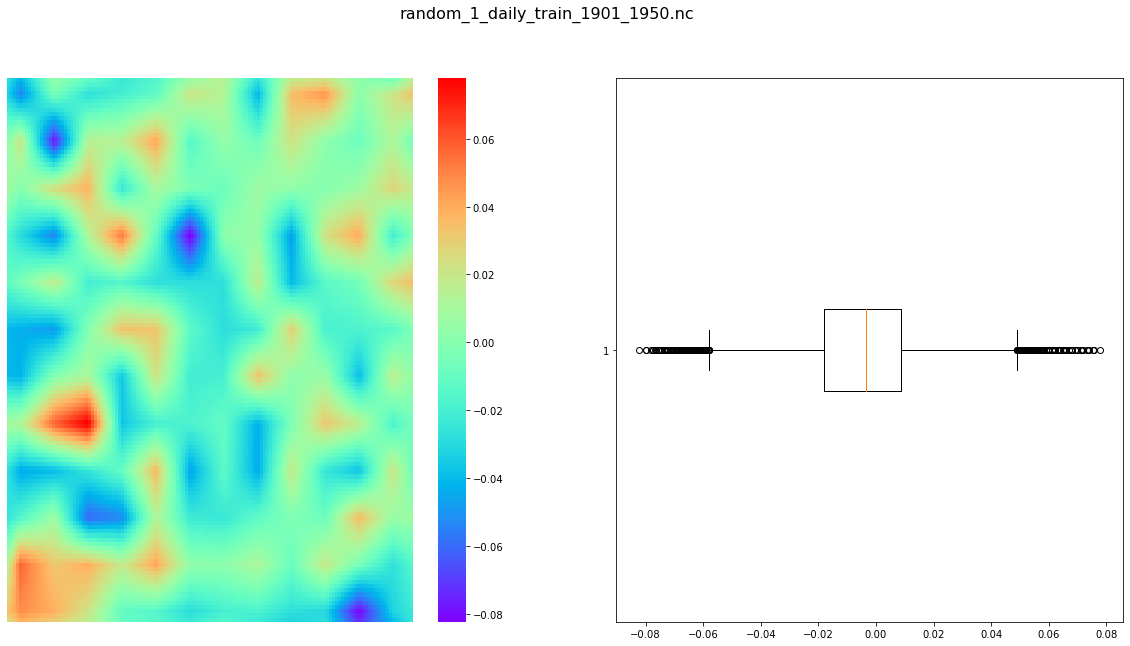

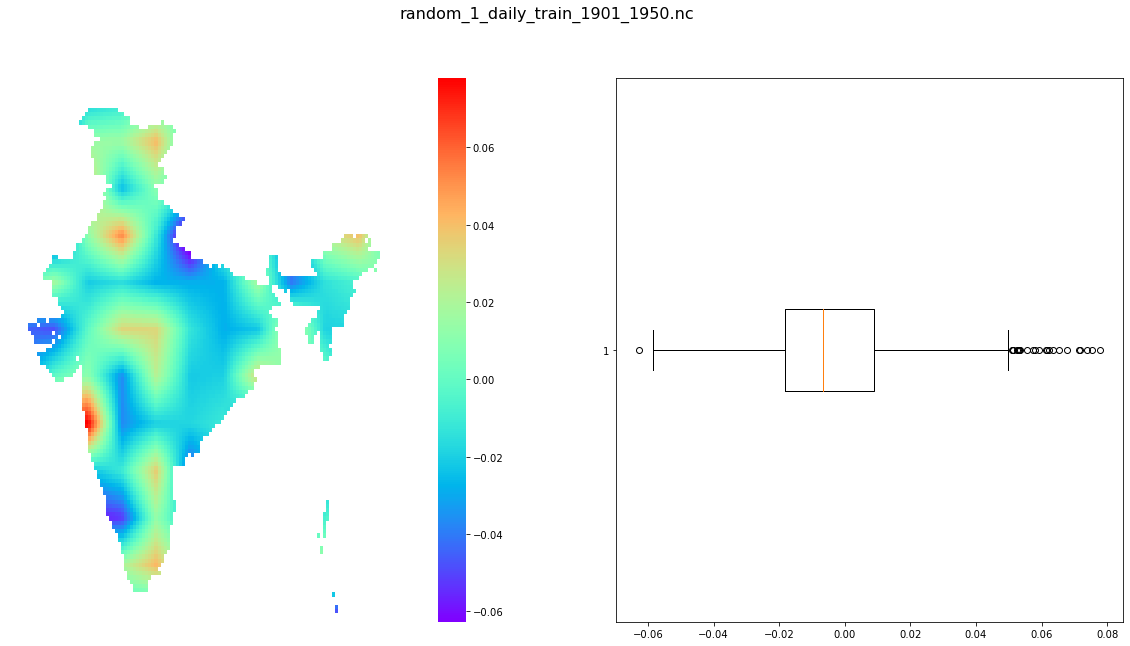

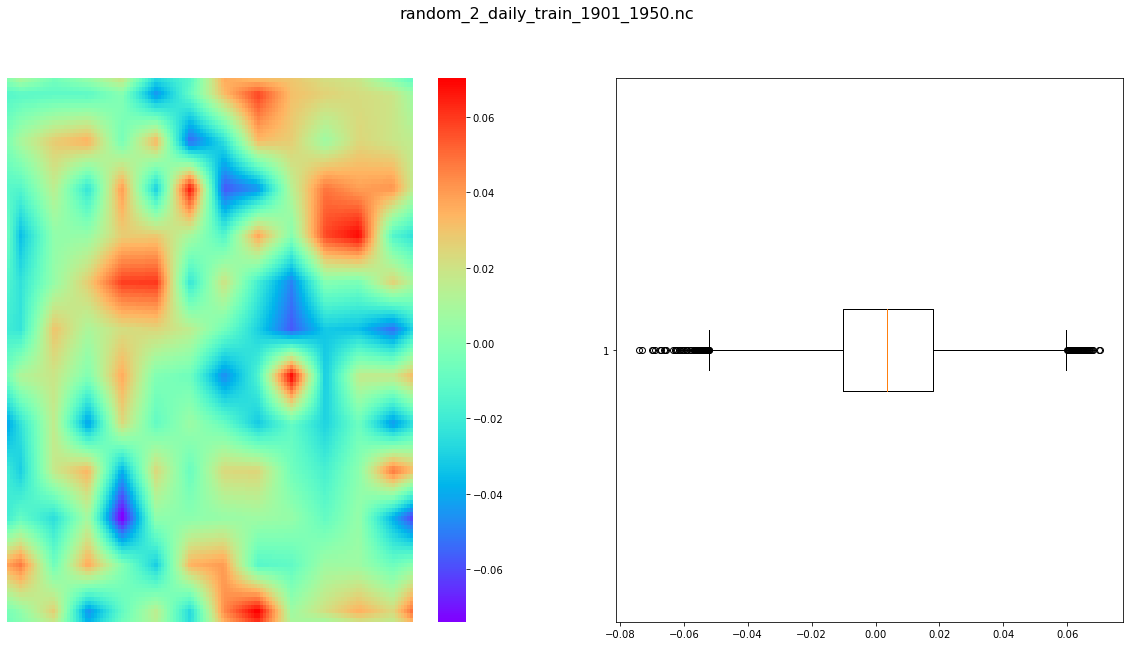

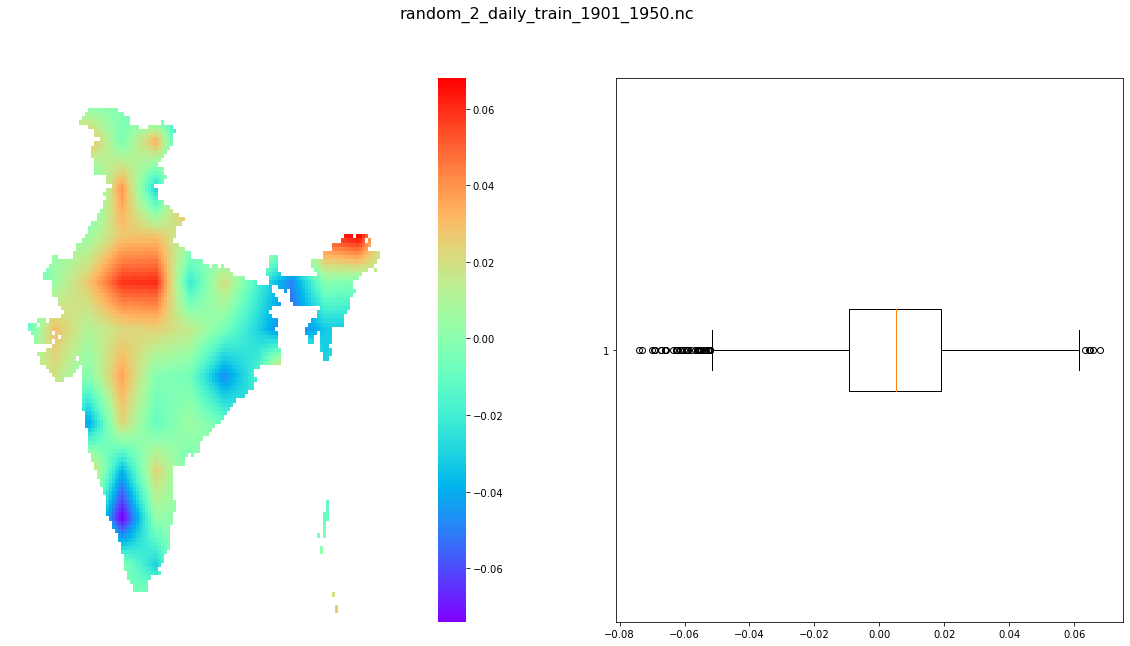

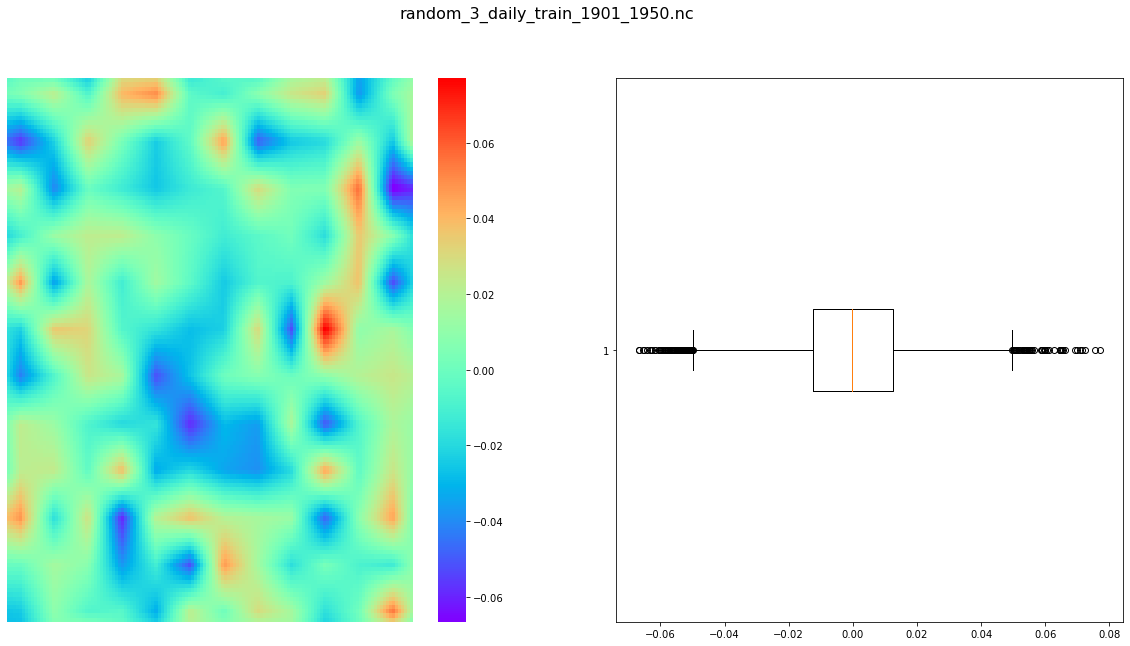

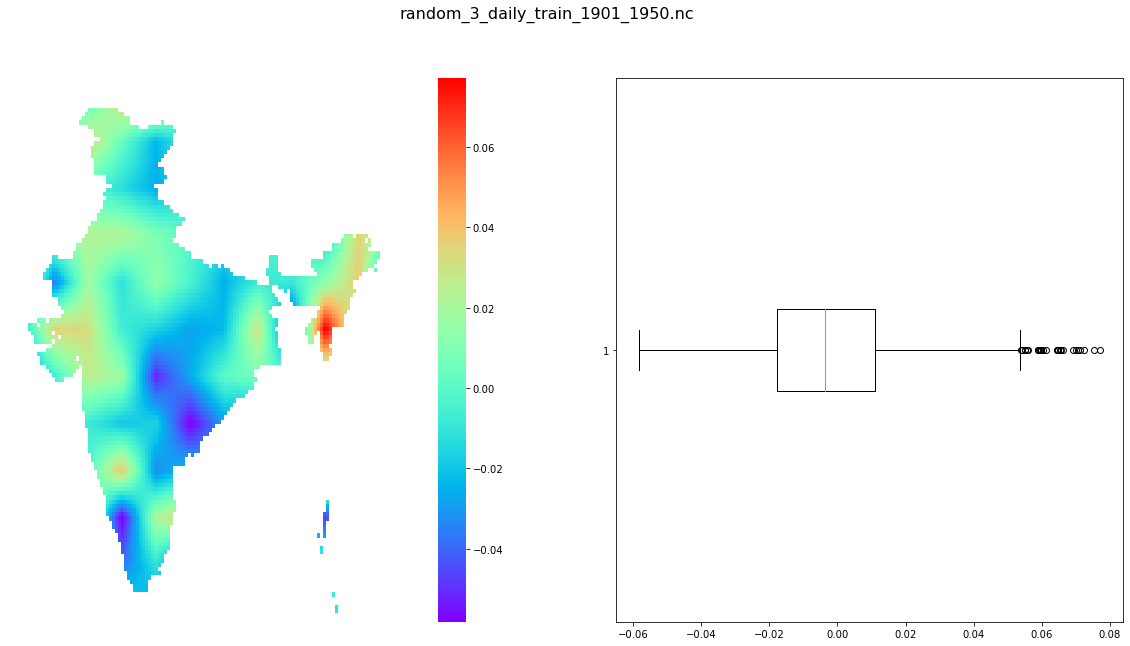

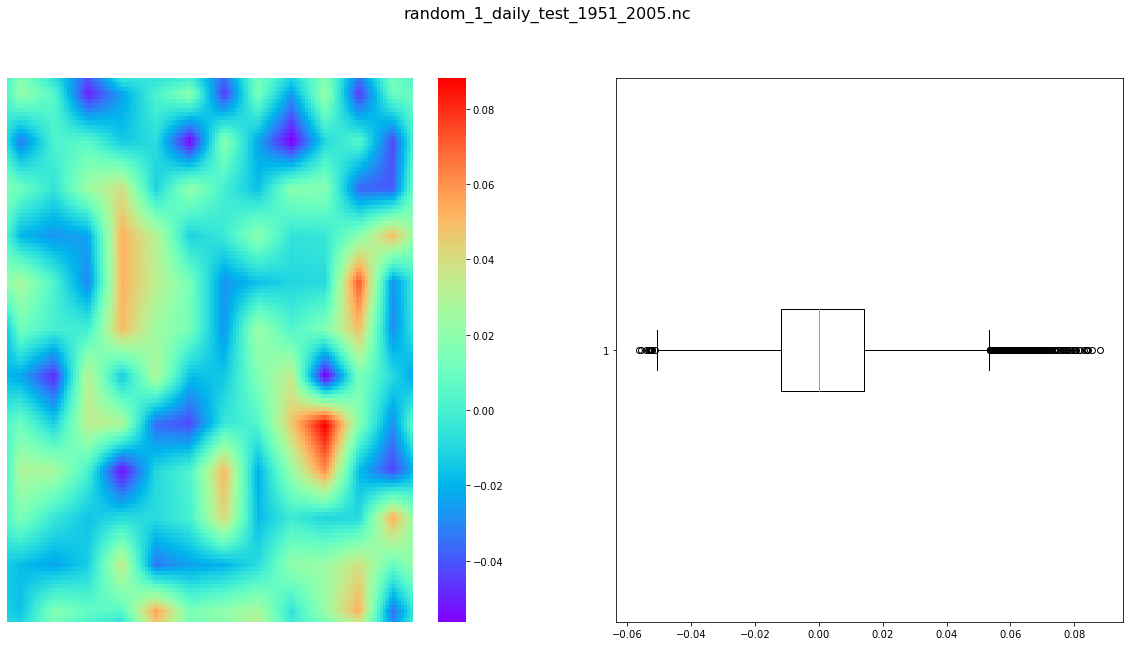

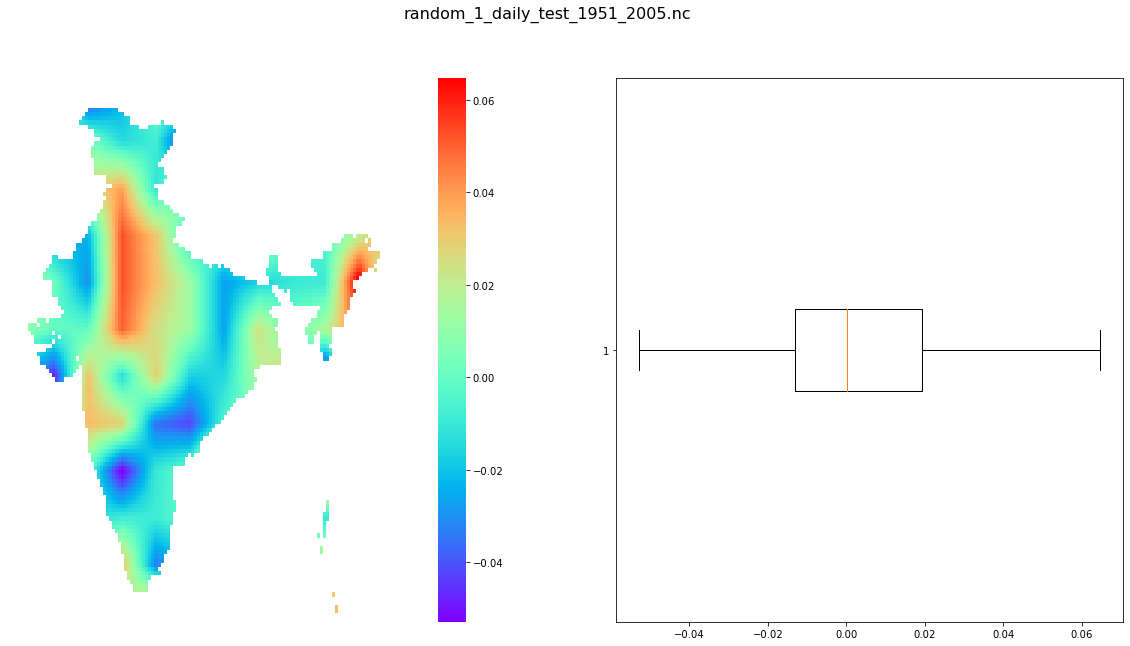

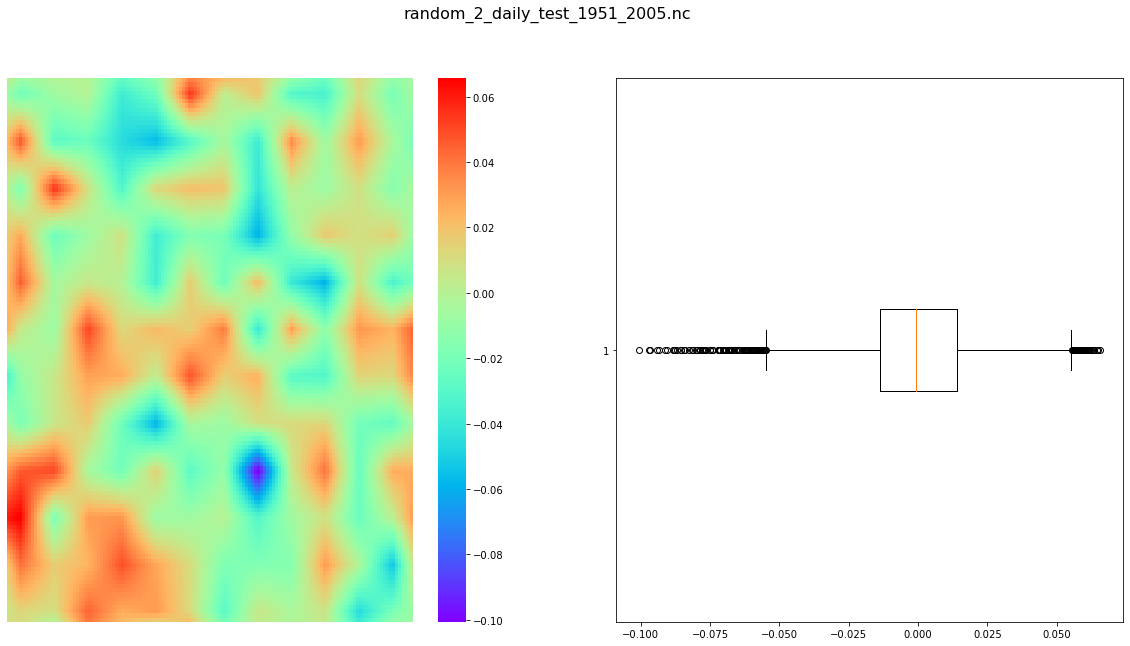

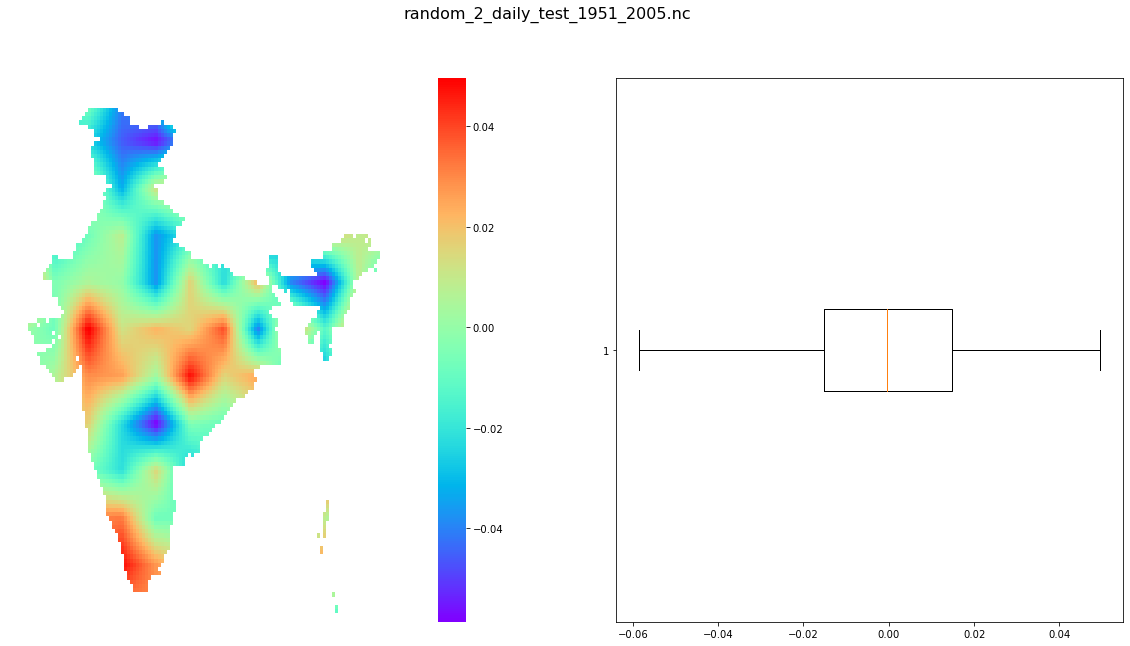

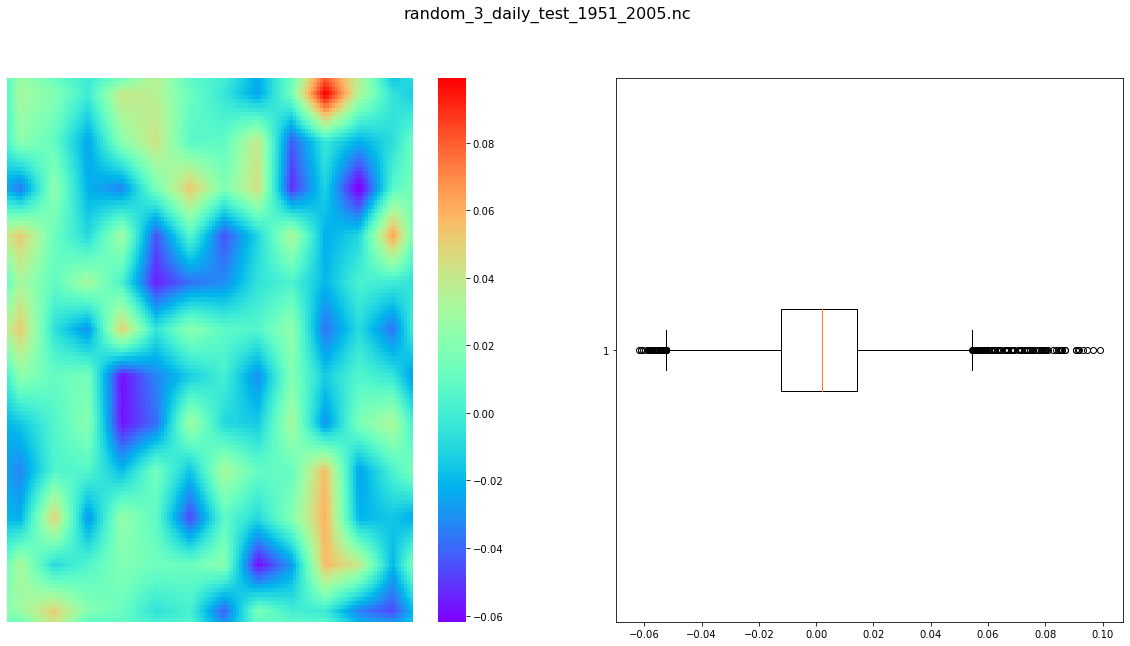

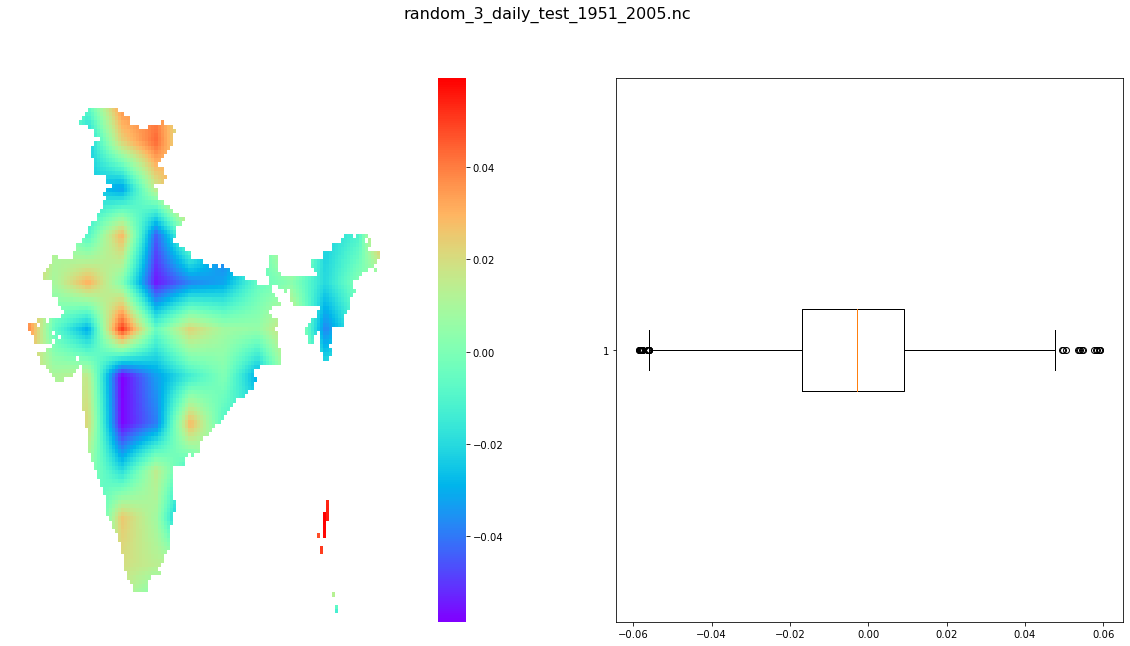

In [18]:
for j in ['train', 'test']:
    for i in [1,2,3]:
        Process(i,j)

In [43]:
for i in [1,2,3]:
    files_list = glob.glob(rf"Data/r{i}_*.nc")
    print(f"{i}: {len(files_list)}")
    ds = xr.open_mfdataset(files_list,combine = 'by_coords')
    print(ds.dims)
    print(ds.coords)
    print()
    ds = ds.sel(time=((ds.time.dt.year >= 1948) & (ds.time.dt.year <= 2005)))
    print(ds.dims)
    print(ds.coords)
    print()
    # ds = ds.sel(time=~((ds.time.dt.month == 2) & (ds.time.dt.day == 29)))
    # ds = ds.sel(time=~((ds.time.dt.month == 2) & (ds.time.dt.day == 30)))

    lat_bnds, lon_bnds = [6.5, 38.5], [66.5, 100]
    projection_dimension = [129, 135]
    lat_lst = np.linspace(lat_bnds[0], lat_bnds[1], projection_dimension[0])
    lon_lst = np.linspace(lon_bnds[0], lon_bnds[1], projection_dimension[1])
    dr = ds['random']
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], lat_lst),
            "lon": (["lon"], lon_lst),
        }
    )
    regridder = xe.Regridder(ds, ds_out, "bilinear")
    dr_out = regridder(dr)
    dr_np = dr_out.to_numpy()
    np.save(
        rf"Data/r{i}.npy",
        dr_np
    )
    print("****************************************************************************")
    print()

1: 2
Frozen({'time': 38351, 'lat': 14, 'lon': 14})
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2005-12-31
  * lat      (lat) float32 4.186 6.977 9.767 12.56 ... 32.09 34.88 37.67 40.46
  * lon      (lon) float32 64.69 67.5 70.31 73.12 ... 92.81 95.62 98.44 101.2

Frozen({'time': 21185, 'lat': 14, 'lon': 14})
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-01-02 ... 2005-12-31
  * lat      (lat) float32 4.186 6.977 9.767 12.56 ... 32.09 34.88 37.67 40.46
  * lon      (lon) float32 64.69 67.5 70.31 73.12 ... 92.81 95.62 98.44 101.2

****************************************************************************

2: 2
Frozen({'time': 38351, 'lat': 14, 'lon': 14})
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2005-12-31
  * lat      (lat) float32 4.186 6.977 9.767 12.56 ... 32.09 34.88 37.67 40.46
  * lon      (lon) float32 64.69 67.5 70.31 73.12 ... 92.81 95.62 98.44 101.2

Frozen({'time': 21185, 'lat': 14, 'lon': 14})

In [50]:
# Reanalysis
for var in ['omega','pres','rhum','uwnd','vwnd']:
    ds = xr.open_dataset(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/02_Raw_Data/NCEP_NCAR_Reanalysis1/{var}_combined.nc")
    ds = ds.sel(time=((ds.time.dt.year >= 1948) & (ds.time.dt.year <= 2005)))
    lat_bnds, lon_bnds = [6.5, 38.5], [66.5, 100]
    projection_dimension = [129, 135]
    lat_lst = np.linspace(lat_bnds[0], lat_bnds[1], projection_dimension[0])
    lon_lst = np.linspace(lon_bnds[0], lon_bnds[1], projection_dimension[1])
    dr = ds[var]
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], lat_lst),
            "lon": (["lon"], lon_lst),
        }
    )
    regridder = xe.Regridder(ds, ds_out, "bilinear")
    dr_out = regridder(dr)
    dr_np = dr_out.to_numpy()
    print(f"{var}: {dr_np.shape}")
    np.save(
        rf"Data/{var}.npy",
        dr_np
    )

omega: (21185, 129, 135)
pres: (21185, 129, 135)
rhum: (21185, 129, 135)
uwnd: (21185, 129, 135)
vwnd: (21185, 129, 135)


In [2]:
ds = xr.open_dataset(r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/02_Raw_Data/IMD_Precipitation.nc")
ds = ds.sel(time=((ds.time.dt.year >= 1948) & (ds.time.dt.year <= 2005)))
dr = ds["rain"]
dr_np = dr.to_numpy()
if min(dr_np.flatten()) < 0:
    dr_np[dr_np == min(dr_np.flatten())] = 0
dr_np = dr_np.reshape(1, 21185, 129, 135)
print(dr_np.shape)
np.save(
    rf"Data/IMD.npy",
    dr_np
)

(1, 21185, 129, 135)


In [52]:
SRTM = np.load(r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy")
SRTM = SRTM.reshape(1,129,135)
elev = np.ones((21185,129,135))
elev = elev*np.array(SRTM)

In [53]:
for i in [1,2,3]:
    X = np.empty((7,21185,129,135))
    X[0,:,:,:] = np.array(np.load(rf"Data/r{i}.npy"))
    X[1,:,:,:] = np.array(elev)
    X[2,:,:,:] = np.array(np.load(rf"Data/rhum.npy"))
    X[3,:,:,:] = np.array(np.load(rf"Data/pres.npy"))
    X[4,:,:,:] = np.array(np.load(rf"Data/uwnd.npy"))
    X[5,:,:,:] = np.array(np.load(rf"Data/vwnd.npy"))
    X[6,:,:,:] = np.array(np.load(rf"Data/omega.npy"))
    np.save(
        rf"Data/X_r{i}.npy",
        X
    )